## Deep learning approach

In [1]:
#Deep learning library of choice PyTorch

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching

import numpy as np
import scipy.stats as stats
import pandas as pd

# Time to check that the gpu optimization is actually helping

import time 

# Some graphing

import matplotlib.pyplot as plt

In [2]:
# use GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# Count the number of CPU cores available, this returns the number of threads, because most cpus have a thread count equal to twice their core count I have halved the count when multithreading
# Set this number to one if you dont want to multi thread the process

cpuCount = os.cpu_count()
print(cpuCount)

cuda:0
24


In [3]:
#bring in the files

df = pd.read_csv('../datalets/datalet2.csv',index_col=False)
df = df.astype('int')


In [4]:
display(df)

,period0,period1
0,3,1
1,1,3
2,3,0
3,0,1
4,1,0
...,...,...
9993,3,1
9994,1,3
9995,3,3
9996,3,0


In [5]:
df['period0'] = df['period0'].apply(lambda x: 'high' if x == 3 else x )
df['period0'] = df['period0'].apply(lambda x: 'med' if x == 2 else x)
df['period0'] = df['period0'].apply(lambda x: 'low' if x == 1 else x)
df['period0'] = df['period0'].apply(lambda x: 'none' if x == 0  else x)

In [6]:
#I am splitting the data into dummy columns rather than keeping it as a single value to help with the batch normalization and with the model training. not strictly necessary though.

dummies = pd.get_dummies(df.period0)

df = pd.concat([df, dummies], axis='columns')

df.drop(['period0'], axis = 'columns')

,period1,high,low,med,none
0,1,1,0,0,0
1,3,0,1,0,0
2,0,1,0,0,0
3,1,0,0,0,1
4,0,0,1,0,0
...,...,...,...,...,...
9993,1,1,0,0,0
9994,3,0,1,0,0
9995,3,1,0,0,0
9996,0,1,0,0,0


In [7]:
#creating the datasets using pytorch. Notice that the data is stored as floats but the labels as a int(longtensor) this is because the loss function gets unhappy if you try to pass it a float for hte lables.
# as it works out probabilities then compares them to the categorical variable. 
dataheaders = dummies.columns

data = torch.Tensor(df[dataheaders].values).type(torch.float)
labels = torch.Tensor(df['period1'].values).type(torch.LongTensor)

In [8]:
print(data)
print(labels)

tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        ...,
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]])
tensor([1, 3, 0,  ..., 3, 0, 0])


In [9]:
# First we are going to split the data into three parts, evaluation, test and training data. I do this with two instances of train_test_split, just for the sake of convinience.

traintemp_data,eval_data, traintemp_labels,eval_labels = train_test_split(data, labels, test_size=.01)

train_data,test_data, train_labels,test_labels = train_test_split(traintemp_data, traintemp_labels, test_size=.01)

#then we are going to pass the data to the Pytorch data loader, this is going to allow us to split it into mini batches that will be run through the model.

train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

train_data = train_data
test_data = test_data

#Best to keep batches to powers of two for speed reasons adjust as needed for your own memory constraints 
x = 6
batches   = 2**x
train_loader = DataLoader(train_data,batch_size=batches,shuffle=True,drop_last=True, num_workers=int(cpuCount/2))
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0]) 

In [10]:
# create a class for the model, I am going to use batch nomralisation to try and make the model 

class ANN(nn.Module):
	def __init__(self, Input_dim, Output_dim):
		super().__init__()

		### input layer
		self.input = nn.Linear(Input_dim,4)
		
		### hidden layers and batch normalisation layers 
		self.hidden1    = nn.Linear(4,4)
		self.bnorm1 = nn.BatchNorm1d(4) 
		self.hidden2    = nn.Linear(4,4)
		self.bnorm2 = nn.BatchNorm1d(4) 
		self.hidden3    = nn.Linear(4,4)
		self.bnorm3 = nn.BatchNorm1d(4)
		self.hidden4    = nn.Linear(4,4)

		### output layer
		self.output = nn.Linear(4,Output_dim)
	
	# forward pass
	def forward(self,x):

		# input (x starts off normalized)
		x = F.relu( self.input(x) )


		# hidden layer 1
		x = self.bnorm1(x) # batchnorm
		x = F.relu( self.hidden1(x) )      # linear function and activation function

		# hidden layer 2
		x = self.bnorm2(x) # batchnorm
		x = F.relu( self.hidden2(x) )      # linear function and activation function
		
		# hidden layer 3
		x = self.bnorm3(x) # batchnorm
		x = F.relu( self.hidden3(x) )      # linear function and activation function
  
		# hidden layer 4

		x = F.relu( self.hidden4(x) )

		# output layer
		return self.output(x)

In [11]:
def trainthemodel(learning):
	
	# Loss function and optimizer, I chose the cross entoply loss for the non binary catagorisation problem. 
	lossfun = nn.CrossEntropyLoss()
	optimizer = torch.optim.SGD(model.parameters(),lr=learning)
	
	#initialize a way to store the losses
	losses = torch.zeros(numofepochs)
	trainAcc = []
	testAcc = []

	model.to(device)
	
	#now lets actually loop over the training epochs to train the model
	for epoch in range(numofepochs):
		
		# switch on training mode
		model.train()

		# loop over training data batches
		batchAcc  = []
		batchLoss = []
		for X,y in train_loader:
    
			#pass the data to the GPU, this seems to be the real bottle neck in training the model

			X = X.to(device)
			y = y.to(device)
			
			# forward pass and loss
			yHat = model(X)
			loss = lossfun(yHat,y)

			# backprop
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# loss from this batch
			batchLoss.append(loss.item())

			#bring this data back to the CPU to calculate the accuracy 
   
			yHat = yHat.cpu()
			y = y.cpu()

			# compute training accuracy for this batch
			batchAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
			
		# now that we've trained through the batches, get their average training accuracy
		trainAcc.append( np.mean(batchAcc)) 

		# and get average losses across the batches
		losses[epoch] = np.mean(batchLoss)
		
		### test accuracy calculations so we can make sure that we are actually improving the accuracy on the train set as we train the data

		# Lets turn eval back on so we dont over fit with the test data 
		model.eval()
		X,y = next(iter(test_loader)) # extract X,y from test dataloader

		#this is small enough it could be done on the CPU but ah well. 

		X = X.to(device)
		y = y.to(device)  

		with torch.no_grad(): # deactivates autograd
			yHat = model(X)

		#back to the CPU to store the test acc data

		yHat = yHat.cpu()
		y = y.cpu()   

		testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1) == y).float()) )
  
		#just timing the epochs so we can check the speed and be sure it is traing at a decent rate and nothing is going wrong.
		#Plus its nice to have some indication it is actually working

		print('epoch {} done at time {} '.format(epoch,time.perf_counter()))


	# function output
	return trainAcc,testAcc,losses,model

In [12]:
input_dim = dummies.shape[1]
output_dim = 4
numofepochs = 5
learningrate = 0.01

model = ANN(Input_dim = input_dim,Output_dim = output_dim)
trainAcc,testAcc,losses,model = trainthemodel(learningrate)

epoch 0 done at time 19.0004733 
epoch 1 done at time 22.9579021 
epoch 2 done at time 26.1933856 
epoch 3 done at time 30.1090999 
epoch 4 done at time 33.3070111 


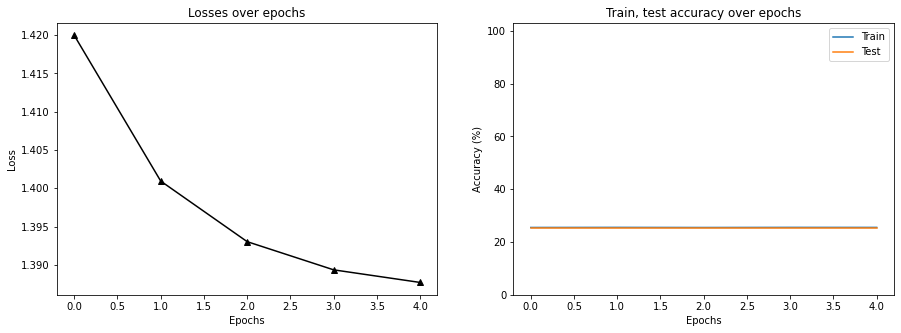

In [13]:
#Just some plots to be sure that we are doing the things we want to do

fig,ax = plt.subplots(1,2,figsize=(15,5))



ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses over epochs')

ax[1].plot(trainAcc,)
ax[1].plot(testAcc,)
ax[1].set_title('Train, test accuracy over epochs')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])
ax[1].set_ylim([0,103])

plt.show()



In [14]:
torch.save(model.state_dict(),'../Deeplearningmodels/markovchainappoximation.pt')